In [33]:
%matplotlib inline
import numpy as np
import os
from paper_plot import *
from matplotlib.ticker import FormatStrFormatter
from scipy.integrate import quad
from xml.etree import ElementTree as ET
from astropy.time import Time
from myfunctions import MET_to_MJD
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import math
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from scipy.interpolate import UnivariateSpline
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
MeV_to_erg = 1.60218e-6

In [34]:
MET_to_MJD(545628202)

array(58225.14196972222)

In [35]:
def create_index_pdf(x, g, dg):
    probs = [norm.pdf(x, g[i], dg[i]) for i in range(len(g))]
    return np.sum(probs)

def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

def weighted_median(values, weights):
    sinds = np.argsort(values)
    csum = np.cumsum(weights[sinds])
    median_ind = int(np.where(csum>np.max(csum)/2)[0][0]) 
    return (values[sinds])[median_ind]

In [36]:
def get_flux(this_dict):
    if this_dict['type'] == 'PowerLaw':
        return lambda E: powerlaw(E, this_dict['Prefactor'][0],
                                 this_dict['Index'][0], this_dict['Scale'][0])
    if this_dict['type'] == 'LogParabola':
        return lambda E: log_parabola(E, this_dict['norm'][0],
                                 this_dict['alpha'][0], this_dict['beta'][0], this_dict['Eb'])
    
def get_rel_error(this_dict):
    if (this_dict['type'] == 'PowerLaw'): 
        return lambda E: powerlaw_err(E, this_dict['Prefactor'][0], this_dict['Prefactor'][1],
                                 this_dict['Index'][1], this_dict['Scale'][0], this_dict['cov'] )
    if (this_dict['type'] == 'LogParabola'): ##could be wrong, just for testing
        return lambda E: powerlaw_err(E, this_dict['norm'][0], this_dict['norm'][1],
                                 this_dict['alpha'][1], this_dict['Eb'][0] )
        
@np.vectorize
def powerlaw(E, prefactor, index, E0):
    return prefactor*(E/E0)**(-index)

@np.vectorize
def log_parabola(E, norm, alpha, beta, Eb):
    return norm*(E/Eb)**(-alpha-beta*np.log(E/Eb))

@np.vectorize
def powerlaw_err(E, norm, dnorm, dindex, E0, cov):
    return np.sqrt((dnorm/norm)**2 + ((np.log(E/E0))**2)*dindex**2+2*cov*np.log(E/E0)/norm)

def ana_ph_flux(this_dict, emin, emax):
    phi0 = this_dict['Prefactor'][0]
    gamma = np.abs(this_dict['Index'][0])
    E0 = this_dict['Scale'][0]
    return phi0/(1-gamma)*((emax/E0)**(-gamma)*emax-(emin/E0)**(-gamma)*emin)
    
def ana_ph_flux_err(this_dict,emin, emax):
    phi0 = this_dict['Prefactor'][0]
    gamma = this_dict['Index'][0]
    E0 = this_dict['Scale'][0]
    dgamma = this_dict['Index'][1]
    dphi0 = this_dict['Prefactor'][1]
    flux = ana_ph_flux(this_dict, emin, emax)
    diff_emax = powerlaw(emax,phi0,gamma,E0)
    diff_emin = powerlaw(emin,phi0,gamma,E0)
    cov = this_dict['cov']
    dPhi_dgamma =flux/(1-gamma)+1/(1-gamma)*(diff_emin*emin*np.log(emin/E0)-diff_emax*emax*np.log(emax/E0))
    dPhi_dPhi0 = flux/phi0
    return np.sqrt((dPhi_dPhi0*dphi0)**2+(dPhi_dgamma*dgamma)**2+2*cov*dPhi_dPhi0*dPhi_dgamma)
    
    
    

In [77]:
source = '3FGL J0509.4+0541' # TXS
path_to_fit_res = './Lightcurve/TXS_78days'
filen = '../Narek/TXS_results_F6.txt' # Adaptive Binning
project ='2000'
llim = 2e3
ulim = 3e5

# source = '3FGL J0509.4+0541' # TXS
# path_to_fit_res = './Lightcurve/TXS_LC'
# filen = '../Narek/TXS_results_F6.txt' # Adaptive Binning
# project ='2000'
# llim = 2e3
# ulim = 3e5

# source = '3FGL J0509.4+0541' # TXS
# path_to_fit_res = './Lightcurve/TXS_110days/'
# filen = '../Narek/TXS_results_F6.txt' # Adaptive Binning
# project ='2000'
# llim = 2e3
# ulim = 3e5

# source = '3FGL J0509.4+0541' # TXS
# path_to_fit_res = './Lightcurve/TXS_LC_5GeV/'
# filen = '../Narek/TXS_results_F6.txt' # Adaptive Binning
# project ='5000'
# llim = 5e3
# ulim = 3e5

# source = '3FGL J0509.4+0541' # TXS
# path_to_fit_res = './Lightcurve/TXS_LC_10GeV/'
# filen = '../Narek/TXS_results_F6.txt' # Adaptive Binning
# project ='10000'þfe
# llim = 10e3
# ulim = 3e5

# source = '3FGL J0505.3+0459' #PKS
# path_to_fit_res = './Lightcurve/PKS_LC_old/'
# filen = '../Narek/pks0502_results.txt' # Adaptive Binning
# project ='100'
# llim = 1e2
# ulim = 3e5


spec_index='Index'
ms = 1.0
lw = 0.7

# New

In [78]:
LC_dict = dict()
bin_length =[]
for time_dir in [dir for dir in os.listdir(path_to_fit_res) if dir[0] == '5']:
    path = '{}/{}/{}/output.npy'.format(path_to_fit_res, time_dir, project)
    if os.path.exists(path):
        odict = np.load(path)[()]
    else:
        continue
    tmid = (float(time_dir.split('_')[1])+float(time_dir.split('_')[0]))/2
    bin_length.append(float(time_dir.split('_')[1])-float(time_dir.split('_')[0]))
    flux_params = dict()
    if 'beta' in odict[source].keys():
        flux_params['type'] = 'LogParabola'
        pref = 'norm'
        sind = 'alpha'
        E0 = 'Eb'
    else:
        flux_params['type'] = 'Powerlaw'  
        pref = 'Prefactor'
        sind = 'Index'
        E0 = 'Scale'
    
    prefactor = odict[source][pref]
    flux_params['Prefactor'] = [prefactor['value']*prefactor['scale'], prefactor['error']*prefactor['scale'] ]
    index = odict[source][sind]
    flux_params['Index'] = [index['value'], index['error'] ]
    flux_params['ts'] = odict[source]['TS']
    flux_params['Scale'] = [odict[source][E0]['value']]
    flux_params['ul'] = odict[source]['UL']['value']
    flux_params['flux'] = odict[source]['flux']
    flux_params['flux_err'] = odict[source]['flux_err']
    flux_params['eflux'] = odict[source]['eflux']
    flux_params['eflux_err'] = odict[source]['eflux_err']
    LC_dict[tmid] = flux_params
times = np.array(sorted(LC_dict.keys()))
#print LC_dict

In [79]:
print LC_dict

{54913.5: {'Index': [2.1526717181929484, 0.33856900284519537], 'Scale': [20000.0], 'flux': 1.4039923080655364e-09, 'eflux': 1.1367006486490655e-05, 'ts': 55.63004099307727, 'flux_err': 4.2014842630700509e-10, 'ul': 1.8334748464716857e-09, 'type': 'Powerlaw', 'eflux_err': 5.7972907742410793e-06, 'Prefactor': [5.709458194582576e-15, 3.0931104279789413e-15]}, 58231.5: {'Index': [3.007241114181224, 0.9015994093076731], 'Scale': [20000.0], 'flux': 1.5177607940659995e-08, 'eflux': 6.006723459803867e-05, 'ts': 38.915022462836305, 'flux_err': 7.0025448044601252e-09, 'ul': 2.0751784180861694e-08, 'type': 'Powerlaw', 'eflux_err': 3.6777780619656471e-05, 'Prefactor': [1.496845860607303e-14, 2.51080198547017e-14]}, 56809.5: {'Index': [2.095537952596707, 0.32210176234136484], 'Scale': [20000.0], 'flux': 1.9849984557382454e-09, 'eflux': 1.7385485249201027e-05, 'ts': 62.47133128587666, 'flux_err': 5.8625322901603271e-10, 'ul': 2.609716172031274e-09, 'type': 'Powerlaw', 'eflux_err': 8.9276497988708213

# Photon_Flux

In [80]:
fpy_ph_flux = np.array([LC_dict[time]['flux'] for time in times])
fpy_ph_flux_err = np.array([LC_dict[time]['flux_err'] for time in times])
fpy_eflux = np.array([LC_dict[time]['eflux'] for time in times])
fpy_eflux_err = np.array([LC_dict[time]['eflux_err'] for time in times])
gamma = np.array([float(LC_dict[time][spec_index][0]) for time in times])
dgamma = np.array([float(LC_dict[time][spec_index][1]) for time in times])
ts = np.array([float(LC_dict[time]['ts']) for time in times])
ul = np.array([float(LC_dict[time]['ul']) for time in times])
pf = np.array([float(LC_dict[time]['Prefactor'][0]) for time in times])
dpf = np.array([float(LC_dict[time]['Prefactor'][1]) for time in times])

In [81]:
print pf

[  8.18983070e-15   8.05641850e-15   5.70945819e-15   8.07151534e-15
   6.05421087e-15   1.11155131e-14   1.18142063e-14   1.07660151e-14
   1.44791836e-14   2.58758057e-14   3.19981062e-14   2.36973568e-14
   8.89700950e-15   1.76070387e-14   9.57169716e-15   5.24744515e-15
   9.44114926e-15   7.86936975e-15   1.70834233e-14   7.66938198e-15
   1.06607849e-14   6.59227095e-15   1.03862645e-14   4.16338064e-15
   1.19166421e-14   1.30099211e-14   8.76003820e-15   3.13695303e-15
   1.10175567e-14   1.04670467e-14   4.22180936e-15   9.31320907e-15
   3.10705322e-15   6.46648056e-15   3.86587249e-15   1.36628481e-14
   1.50697681e-14   1.77685156e-14   1.36506483e-14   6.26340235e-14
   3.59334087e-14   3.21662177e-14   4.86517420e-14   1.49684586e-14]


In [82]:
ts1 = np.array([float(LC_dict[time]['ts']) for time in times])

In [83]:
mjd = [Time(t, format='jyear').mjd for t in np.arange(2009,2019,1)]

In [84]:
outdict = {'time':times, 'ph_flux': fpy_ph_flux, 'ph_flux_err': fpy_ph_flux_err,
          'eflux': fpy_eflux, 'eflux_err': fpy_eflux_err }
np.save('out.npy', outdict)

(0.023518986398667403, 1.8468064535318944e-09)


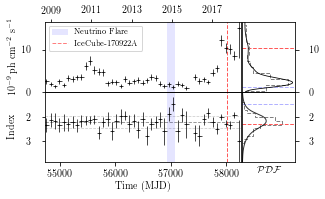

In [90]:
fig = plt.figure(figsize=figsize(0.5, 0.7))
tsmask = (np.abs(ts)>9)
dgamma_mask = np.abs(dgamma)<3.
gamma_mask = (gamma>1.) & (gamma<4.)
mask = tsmask & dgamma_mask & gamma_mask
xerr = (np.array(bin_length)/2)


## Spectral Index Axis
ax2=fig.add_axes((.0, .2,0.78,.40))
av_gamma, std_gamma = weighted_avg_and_std(gamma[mask], weights=1./dgamma[mask])
ax2.axhline(av_gamma,linestyle='--', color='grey',
            alpha=0.85, zorder = -1, linewidth=0.9)
ax2.axhline(av_gamma+std_gamma,linestyle='--',
            color='grey', alpha=0.4, zorder = -1, linewidth=0.75)
ax2.axhline(av_gamma-std_gamma,linestyle='--',
            color='grey', alpha=0.4, zorder = -1, linewidth=0.75)
ax2.errorbar(times[mask], gamma[mask], yerr=dgamma[mask], xerr=xerr[mask],
             linestyle='', ms=ms, fmt='.' , color='k', elinewidth=lw)
ax2.set_ylabel('Index', labelpad=9)
ax2.set_yticks([2,3])
ax2.set_xlim(np.min(times)-30, np.max(times)+30)
ax2.set_ylim(3.9, 0.95)
ax2.set_xlabel('Time (MJD)')
ax2.axvspan(57007-78, 57007+78, alpha=0.1, color='blue', linewidth=0.0)
ax2.axvline(58018, linestyle='--', alpha=0.65, lw=1.0, zorder=-1)
ax2.tick_params(axis='x', which='major', pad=3)

ax4=fig.add_axes((.787, .2,0.21,.40))
# time_mask = ((times  < 56950) | (times > 57050))
g_kde  = gamma[mask] #&time_mask
vals, bins = np.histogram(g_kde, bins= 10)
db = np.diff(bins)[0]
bins = np.concatenate([[bins[0]-db], bins, [bins[-1]+db]])
vals = np.concatenate([[0], vals, [0]])
ax4.plot(vals/db/len(g_kde), setNewEdges(bins), drawstyle="steps-mid",
         color='grey', linestyle='--', label = "Histogram")
pdf = lambda x: create_index_pdf(x,g_kde, dgamma[mask]) #&time_mask
x_plot=np.linspace(1.0, 4.0, 1000)
yplot = [pdf(i)/len(g_kde) for i in x_plot]
#ax4.plot(yplot, x_plot, linestyle = '--', color='k')
spl = lambda x: 10**UnivariateSpline(x_plot, np.log10(yplot), k=1, s=0)(x)
print quad(lambda x: spl(x), 0, np.min(g_kde))
ax4.plot(spl(x_plot), x_plot, alpha =0.8, linewidth=1.,
         label = 'KDE', color='k')
ax4.axhline(gamma[int(np.where(times==57046.5)[0])], linestyle='--',
           alpha=0.3, lw=1.0, zorder=-1, color='blue')
ax4.axhline(gamma[int(np.where(times==57994.5)[0])], linestyle='--',
           alpha=0.65, lw=1.0, zorder=-1, color='red')
ax4.set_xlim(0.,)
ax4.set_ylim(3.9, 0.95)
ax4.set_yticks([2,3])
ax4.yaxis.tick_right()
ax4.set_xlabel(r'$\mathcal{PDF}$')
ax4.xaxis.set_ticks([])


## Flux Axis
ax3=fig.add_axes((.0, .60,0.78,.4))
ydata = fpy_ph_flux[mask] #np.concatenate(plt_ph_flux[:,0:1])[mask]
scaling = -round(np.max(np.log10(ydata)))+1
ax3.errorbar(times[mask], 10**scaling*ydata, yerr = 10**scaling*fpy_ph_flux_err[mask],
             xerr=xerr[mask], ms=ms, fmt='.', color='k', elinewidth=lw)
plt_ul = (10**scaling*ul)[~tsmask]
ax3.errorbar(times[~tsmask], plt_ul, xerr=xerr[~tsmask], fmt=' ',
             color='#808080', elinewidth=lw)
ax3.errorbar(times[~tsmask], plt_ul, yerr=0.1*np.ones(len(plt_ul)), fmt=' ' ,
             color='#808080', uplims=True, capsize=0.3, elinewidth=0.3)
ax3.set_xlim(np.min(times)-30, np.max(times)+30)
ax3.set_ylabel(r'$10^{'+'{:.0f}'.format(-scaling)+'}\,$'+r'ph cm$^{-2}$ s$^{-1}$')
ax3.xaxis.set_ticks(mjd[::2])
ax3.xaxis.tick_top()
fig.canvas.draw()
labels = [r'${:.0f}$'.format(Time(item.get_position()[0], format='mjd').decimalyear)
          for item in ax3.get_xticklabels()]
ax3.set_xticklabels(labels)
ax3.axvspan(57007-78,57007+78, alpha=0.1, color='blue', linewidth=0.0)
ax3.axvline(58018, linestyle='--', alpha=0.65, lw=1.0, zorder=-1)
ax3.tick_params(axis='x', which='major', pad=3)
ax3.set_ylim(0, 1.1*np.max(10**scaling*ydata))
flare_lab = mpatches.Patch(color='blue', alpha=0.1, label='Neutrino Flare', linewidth=0)
ehe_lab = mlines.Line2D([],[],color='red', linestyle='--', alpha=0.5, label='IceCube-170922A', lw=1.0)
ax3.legend(loc='upper left',handles=[flare_lab,ehe_lab], fontsize=8)


ax5=fig.add_axes((.787, .60,0.21,.40))
flux_kde  = 10**scaling*fpy_ph_flux[mask] #&time_mask
vals, bins = np.histogram(flux_kde, bins= 10)
db = np.diff(bins)[0]
bins = np.concatenate([[bins[0]-db], bins, [bins[-1]+db]])
vals = np.concatenate([[0], vals, [0]])
ax5.plot(vals/db/len(flux_kde), setNewEdges(bins), drawstyle="steps-mid",
         color='grey', linestyle='--', label = "Histogram")
pdf = lambda x: create_index_pdf(x,flux_kde, 10**scaling*fpy_ph_flux_err[mask]) #&time_mask
x_plot=np.linspace(0, 20.0, 1000)
yplot = [pdf(i)/len(flux_kde) for i in x_plot]
spl = lambda x: 10**UnivariateSpline(x_plot, np.log10(yplot), k=1, s=0)(x)
ax5.plot(spl(x_plot), x_plot, alpha =1.0, linewidth=0.8,
         label = 'KDE', color='k')
ax5.axhline(flux_kde[int(np.where(times[mask]==57046.5)[0])], linestyle='--',
           alpha=0.3, lw=1.0, zorder=-1, color='blue')
ax5.axhline(flux_kde[int(np.where(times[mask]==57994.5)[0])], linestyle='--',
           alpha=0.65, lw=1.0, zorder=-1, color='red')
ax5.yaxis.tick_right()
ax5.xaxis.set_ticks([])
ax5.set_ylim(0, 1.1*np.max(10**scaling*ydata))


plt.savefig('{}_spectral_index_curve_{}_78days.pdf'.format(source,llim/1e3), bbox_inches='tight')
plt.show()

In [89]:
print times


[ 54755.5  54834.5  54913.5  54992.5  55071.5  55150.5  55229.5  55308.5
  55387.5  55466.5  55545.5  55624.5  55703.5  55782.5  55861.5  55940.5
  56019.5  56098.5  56177.5  56256.5  56335.5  56414.5  56493.5  56572.5
  56651.5  56730.5  56809.5  56888.5  56967.5  57046.5  57125.5  57204.5
  57283.5  57441.5  57520.5  57599.5  57678.5  57757.5  57836.5  57915.5
  57994.5  58073.5  58152.5  58231.5]


# Spectral Index Distribution

(0.022990876450003927, 9.60601385811131e-09)


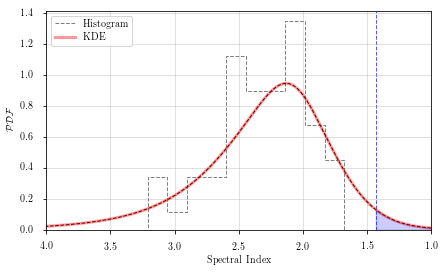

In [346]:
fig, ax = newfig(0.9)
time_mask = ((times  < 56950) | (times > 57050))
g_kde  = gamma[mask&time_mask]
vals, bins = np.histogram(g_kde, bins= 10)
db = np.diff(bins)[0]
bins = np.concatenate([[bins[0]-db], bins, [bins[-1]+db]])
vals = np.concatenate([[0], vals, [0]])
plt.plot(setNewEdges(bins), vals/db/len(g_kde), drawstyle="steps-mid",
         color='gray', linestyle='--', label = "Histogram")
pdf = lambda x: create_index_pdf(x,g_kde, dgamma[mask&time_mask])
x_plot=np.linspace(1.0, 4.0, 1000)
yplot = [pdf(i)/len(g_kde) for i in x_plot]
plt.plot(x_plot, yplot, linestyle = '--', color='k')
spl = lambda x: 10**UnivariateSpline(x_plot, np.log10(yplot), k=1, s=0)(x)
g_min = np.min(gamma[mask])
print quad(lambda x: spl(x), 0, g_min)
plt.plot(x_plot, spl(x_plot), alpha =0.4, linewidth=3.,
         label = 'KDE')
ax.axvline(g_min, linestyle='--',
           alpha=0.65, lw=1.0, zorder=-1, color='blue')
ax.fill_between(np.linspace(g_min, 1.0, 20), 0, spl(np.linspace(g_min, 1.0, 20)),
                color= 'blue', alpha=0.2)
ax.set_xlim(4.0, 1.0)
ax.set_ylim(0.,)
ax.set_xlabel('Spectral Index')
ax.set_ylabel(r'$\mathcal{PDF}$')
plt.legend(loc='best')
plt.grid(True)
# plt.savefig('index_distribution.pdf')

# Adaptive Binning Neutrino Flare

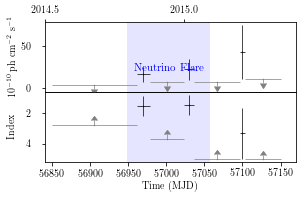

In [157]:
import math
fig = plt.figure(figsize=figsize(0.5, 0.7))
mjd = [Time(t, format='jyear').mjd for t in [2014.5, 2015.0,2015.5]]
data = np.genfromtxt(filen)
times = np.array([float(MET_to_MJD(j)) for j in np.concatenate(data[:,0:1])])
deltaT = np.concatenate(data[:,1:2])/(24*60*60)

ax1=fig.add_axes((.0, .2,1.0,.40))
ax1.invert_yaxis()
ydata = -np.concatenate(data[:,4:5])
yerr = np.concatenate(data[:,5:6])
ulmask = yerr == 0 
ax1.errorbar(times[~ulmask], ydata[~ulmask],
             yerr=yerr[~ulmask], xerr=deltaT[~ulmask], linestyle='',
             ms=ms, fmt='.' , color='k', elinewidth=lw)
a = ax1.errorbar(times[ulmask], ydata[ulmask],
             yerr=0.3*np.ones(len(yerr))[ulmask], xerr=deltaT[ulmask], uplims=True,
             linestyle='', ms=ms, fmt='.' , color='#808080', elinewidth=lw)
ax1.set_xlim(mjd[0], 57170)
ax1.set_ylabel('Index', labelpad=9) #, labelpad=14


# Ax2
ax2=fig.add_axes((.0, .60,1.0,.4))
ydata = np.concatenate(data[:,2:3])
scaling = -(math.floor(np.max(np.log10(ydata))))+1
yerr = np.concatenate(data[:,3:4])
ax2.errorbar(times[~ulmask], (ydata*10**scaling)[~ulmask], yerr=(10**scaling*yerr)[~ulmask],
             xerr=deltaT[~ulmask], linestyle='', ms=ms, fmt='.' , color='k', elinewidth=lw)
ax2.errorbar(times[ulmask], (ydata*10**scaling)[ulmask], yerr=(5*np.ones(len(yerr)))[ulmask], uplims=True,
             xerr=deltaT[ulmask], linestyle='', ms=ms, fmt='.' , color='#808080', elinewidth=lw)
ax2.xaxis.set_ticks(mjd)
ax2.xaxis.tick_top()
fig.canvas.draw()
labels = [r'${:.1f}$'.format(Time(item.get_position()[0], format='mjd').decimalyear)
          for item in ax2.get_xticklabels()]
ax2.set_xticklabels(labels)
ax2.set_xlim(mjd[0], 57170)
ax2.set_ylabel(r'$10^{'+'{:.0f}'.format(-scaling)+'}\,$'+r'ph cm$^{-2}$ s$^{-1}$') #labelpad=14) # labelpad=12


ax2.text(56958., 20,
          'Neutrino Flare', fontsize=11, color ='blue')
ax1.set_xlabel('Time (MJD)')
ax2.axvspan(56948,57058, alpha=0.1, color='blue', linewidth=0.0)
ax1.axvspan(56948, 57058, alpha=0.1, color='blue', linewidth=0.0)
ax1.tick_params(axis='x', which='major', pad=3)
ax2.tick_params(axis='x', which='major', pad=3)
plt.savefig(filen.split('/')[-1][:-4]+'.pdf', bbox_inches='tight')
plt.show()

# All-Time SED

1.45901483779


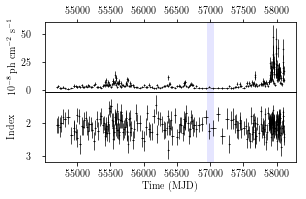

In [141]:
import math
fig = plt.figure(figsize=figsize(0.5, 0.7))
# mjd = [Time(t, format='jyear').mjd for t in [2014.5, 2015.0,2015.5]]
filen = '../Narek/TXS0506+056_results_fin_12degree_238.6.txt'
data = np.genfromtxt(filen)
times = np.array([float(MET_to_MJD(j)) for j in np.concatenate(data[:,0:1])])
deltaT = np.concatenate(data[:,1:2])/(24*60*60)

ax1=fig.add_axes((.0, .2,1.0,.40))
ax1.invert_yaxis()
ydata = -np.concatenate(data[:,4:5])
yerr = np.concatenate(data[:,5:6])
ulmask = yerr == 0 
print np.min(ydata[~ulmask])
ax1.errorbar(times[~ulmask], ydata[~ulmask],
             yerr=yerr[~ulmask], xerr=deltaT[~ulmask], linestyle='',
             ms=ms, fmt='.' , color='k', elinewidth=lw)
ax1.errorbar(times[ulmask], ydata[ulmask],
             yerr=0.3*np.ones(len(yerr))[ulmask], xerr=deltaT[ulmask], uplims=True,
             linestyle='', ms=ms, fmt='.' , color='#808080', elinewidth=lw)
ax1.set_ylabel('Index', labelpad=9) #, labelpad=14


# Ax2
ax2=fig.add_axes((.0, .60,1.0,.4))
ydata = np.concatenate(data[:,2:3])
scaling = -(math.floor(np.max(np.log10(ydata))))+1
yerr = np.concatenate(data[:,3:4])
ax2.errorbar(times[~ulmask], (ydata*10**scaling)[~ulmask], yerr=(10**scaling*yerr)[~ulmask],
             xerr=deltaT[~ulmask], linestyle='', ms=ms, fmt='.' , color='k', elinewidth=lw)
ax2.errorbar(times[ulmask], (ydata*10**scaling)[ulmask], yerr=(5*np.ones(len(yerr)))[ulmask], uplims=True,
             xerr=deltaT[ulmask], linestyle='', ms=ms, fmt='.' , color='#808080', elinewidth=lw)
ax2.xaxis.tick_top()
ax2.set_ylabel(r'$10^{'+'{:.0f}'.format(-scaling)+'}\,$'+r'ph cm$^{-2}$ s$^{-1}$') #labelpad=14) # labelpad=12


ax1.set_xlabel('Time (MJD)')
ax2.axvspan(56948,57058, alpha=0.1, color='blue', linewidth=0.0)
ax1.axvspan(56948, 57058, alpha=0.1, color='blue', linewidth=0.0)
ax1.tick_params(axis='x', which='major', pad=3)
ax2.tick_params(axis='x', which='major', pad=3)
plt.savefig(filen.split('/')[-1][:-4]+'.pdf', bbox_inches='tight')
plt.show()

In [138]:
print  ydata[~ulmask]

[  1.98381633e-08   2.85911707e-08   1.53474712e-08   1.30564661e-08
   2.46690095e-08   1.29340631e-08   7.99774452e-09   1.36092562e-08
   3.63817010e-08   2.74749858e-08   3.57889762e-08   2.62593108e-08
   2.70003939e-08   2.80323828e-08   2.23282570e-08   3.74374034e-08
   2.31214719e-08   2.57471701e-08   2.94310222e-08   2.74111943e-08
   3.69156875e-08   3.17315332e-08   2.47859978e-08   2.65293503e-08
   3.69053803e-08   5.12674891e-08   2.27225658e-08   2.62373576e-08
   2.72355295e-08   1.79483799e-08   3.56108970e-08   4.03284394e-08
   3.96010216e-08   6.89017294e-08   8.43910501e-08   4.43302145e-08
   4.34356156e-08   3.56570688e-08   6.44631026e-08   4.99195776e-08
   4.21767737e-08   4.06603041e-08   2.50839007e-08   4.75488606e-08
   7.30787583e-08   6.02242595e-08   8.06803733e-08   5.94292806e-08
   6.51291288e-08   1.30607310e-07   4.36581301e-08   9.93771309e-08
   1.05313125e-07   6.26987370e-08   2.37750158e-08   5.19061015e-08
   6.18603332e-08   7.79200284e-08

In [62]:
x = []
y = []
x_pt = np.array([1e3, 1e4, 1e5])
for key in sorted(LC_dict.keys()):
    print '{} phi0: {}, gamma {}, scale: {}'.format(key, LC_dict[key]['Prefactor'][0], LC_dict[key]['Index'][0], LC_dict[key]['Scale'][0])
    func = lambda E: powerlaw(E, LC_dict[key]['Prefactor'][0], LC_dict[key]['Index'][0], LC_dict[key]['Scale'])
    x.extend(x_pt)
    y.extend(func(x_pt))

54776.5 phi0: 6.84325556645e-15, gamma 2.56626519522, scale: 20000.0
54831.5 phi0: 5.81620433433e-15, gamma 2.16195683969, scale: 20000.0
54886.5 phi0: 6.64453624022e-15, gamma 1.80482171462, scale: 20000.0
54941.5 phi0: 4.24887626602e-15, gamma 2.49942912832, scale: 20000.0
54996.5 phi0: 9.11594719637e-15, gamma 2.29841001927, scale: 20000.0
55051.5 phi0: 1.18939945807e-15, gamma 3.05072374143, scale: 20000.0
55106.5 phi0: 1.86992800638e-14, gamma 1.83137384446, scale: 20000.0
55161.5 phi0: 5.0958298437e-15, gamma 2.76290323815, scale: 20000.0
55216.5 phi0: 1.32950968154e-14, gamma 1.99502861302, scale: 20000.0
55271.5 phi0: 9.03885793328e-15, gamma 2.52351008197, scale: 20000.0
55326.5 phi0: 1.17818143462e-14, gamma 2.290168191, scale: 20000.0
55381.5 phi0: 1.54019389289e-14, gamma 2.0600024067, scale: 20000.0
55436.5 phi0: 9.4566125933e-15, gamma 2.52774681873, scale: 20000.0
55491.5 phi0: 3.57276396547e-14, gamma 1.99972531212, scale: 20000.0
55546.5 phi0: 3.86454395883e-14, gamma 

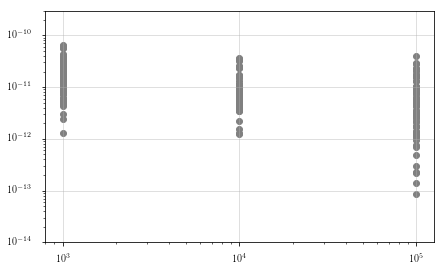

In [65]:
fig, ax = newfig(0.9)
ax.scatter(x, np.array(y)*np.array(x)**2*1.60218e-6, color='gray')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(0.1e-13, 3e-10)
ax.grid(True)
fig.savefig('sed.png', dpi= 300)